## **H3K36, analysis @Pixar**

## **Import modules**

In [1]:
import os
import sys

data_path=os.path.abspath('/media/dataHog/hca/SETD2') #Where your group data is
base_path=os.path.abspath('/media/dataHog/hca/SimFound_v2/source/') #Where your source code is (SFv2)

sys.path.append(base_path)
sys.path.append(data_path)

import importlib

import warnings
warnings.filterwarnings('ignore')
import Protocols as P

import main
import tools
import Trajectory
import MSM
import Featurize as F
import Discretize
import hvplot.pandas as hvplot
importlib.reload(Trajectory)


from simtk.unit import *

## **Define Project**

In [2]:
importlib.reload(Trajectory)
importlib.reload(main)

workdir=data_path
results=workdir+'/results'
inputs=workdir+'/inputs/structures/'

protein=['h3K36']
parameters=['310K']
timestep=20*picoseconds

project=main.Project(title='h3k36', 
                     hierarchy=('protein', 'parameter'), 
                     workdir=workdir,
                     parameter=parameters, 
                     replicas=10, 
                     protein=protein, 
                     topology='h3K36_X.pdb',
                     timestep=timestep,
                    initial_replica=1)
project.setSystems()

Working on /media/dataHog/hca/SETD2
310K
Inputs:
/media/dataHog/hca/SETD2/inputs/structures
/media/dataHog/hca/SETD2/inputs/forcefields


## **Markov State Models**


In [58]:
importlib.reload(MSM)
importlib.reload(Trajectory)
import tools_plots
importlib.reload(tools_plots)

protein_regions = {'all' : 'protein and backbone'}

features_to_extract=['torsions', 'positions']


kinetic_models={}
kinetics=MSM.MSM(project,
                 protein_regions,
                 stride=1, 
                 timestep=timestep, 
                 warnings=True,
                def_traj=['production_NPT-1.dcd', 'production_NPT-2.dcd'])

Results will be stored under:  /media/dataHog/hca/SETD2/results/h3K36-310K/MSM
PyEMMA calculations will be stored under:  /media/dataHog/hca/SETD2/results/h3K36-310K/MSM/MSM_storage
Using pre-defined trajectory ['production_NPT-1.dcd', 'production_NPT-2.dcd'] and/or topology None


In [42]:
states = [5, 10, 15, 20, 30, 50, 100]
lags = [10, 100, 250, 500, 1000, 2000]
tica_lags=[10, 20, 50, 100, 200, 500, 1000, 2000]

test_models = []

for region in protein_regions.keys():
    for feature in features_to_extract:
        test_models.append((region, feature, states, lags))

kinetics.analysis(inputs=test_models, 
                    method='generate', 
                    tica_lag=tica_lags,
                    eval_vamps=True, 
                  tica_weights='empirical')

Executing load_models 
	Models calculated:  247
	Models to discard:  425
	Models to calculate:  0
	Failed models:  425
	Loaded models:  247
	Total number of models : 672


In [4]:
models=kinetics.model_comparison()
passed_models=models[models['Test'] == True]
failed_models=models[models['Test'] == False]
#ranked_models=passed_models.sort_values('Score', ascending=False)
passed_models

32 files collected.
Subset with VAMP2 cv


Discretized feature    feature name       model  Test  \
1          torsions@200ps   torsions  all    10@200ps  True   
2          torsions@200ps   torsions  all    15@200ps  True   
3          torsions@200ps   torsions  all    20@200ps  True   
4          torsions@200ps   torsions  all    30@200ps  True   
8          torsions@200ps   torsions  all   10@2000ps  True   
...                   ...        ...  ...         ...   ...   
13422   positions@40000ps  positions  all  20@10000ps  True   
13423   positions@40000ps  positions  all  30@10000ps  True   
13424   positions@40000ps  positions  all  50@10000ps  True   
13428   positions@40000ps  positions  all  15@20000ps  True   
13434   positions@40000ps  positions  all  10@40000ps  True   

                                                 Filters  Processes  States  \
1      connectivity counts time_resolved reversible f...          7      10   
2      connectivity counts time_resolved reversible f...         13      15   
3      connectivity counts time_resolved reversible f...         13      20   
4      connectivity counts time_resolved reversible f...         18      30   
8      connectivity counts time_resolved reversible f...          8      10   
...                                                  ...        ...     ...   
13422  connectivity counts time_resolved reversible f...          3      20   
13423  connectivity counts time_resolved reversible f...          3      30   
13424  connectivity counts time_resolved reversible f...          3      50   
13428  connectivity counts time_resolved reversible f...          3      15   
13434  connectivity counts time_resolved reversible f...          4      10   

        Lag  Cluster method  Dimensions  tICA lag re-weighting   VAMP2cv  \
1        10             NaN          24        10      koopman   VAMP2 1   
2        10             NaN          24        10      koopman   VAMP2 1   
3        10             NaN          24        10      koopman   VAMP2 1   
4        10             NaN          24        10      koopman   VAMP2 1   
8       100             NaN          28        10      koopman   VAMP2 1   
...     ...             ...         ...       ...          ...       ...   
13422   500             NaN          78      2000    empirical  VAMP2 10   
13423   500             NaN          78      2000    empirical  VAMP2 10   
13424   500             NaN          78      2000    empirical  VAMP2 10   
13428  1000             NaN          78      2000    empirical  VAMP2 10   
13434  2000             NaN          78      2000    empirical  VAMP2 10   

          Score  
1      9.309800  
2      9.480890  
3      9.493843  
4      9.605151  
8      6.405974  
...         ...  
13422  2.806870  
13423  2.463676  
13424  3.431479  
13428  2.408658  
13434  2.560105  

[4600 rows x 15 columns]

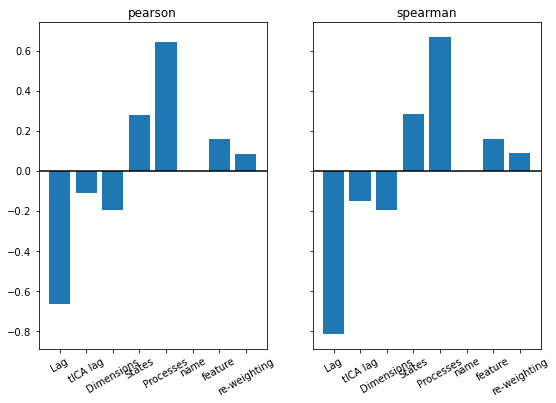

In [5]:
kinetics.plot_correlations(passed_models)

In [7]:
passed_models.hvplot.box(y='Score', by=['re-weighting', 'Lag'], rot=30)

:BoxWhisker   [re-weighting,Lag]   (Score)

In [8]:
passed_models.hvplot.box(y='Score', by=['re-weighting','tICA lag'], rot=30)

:BoxWhisker   [re-weighting,tICA lag]   (Score)

In [9]:
passed_models.hvplot.heatmap(x='Lag', y='tICA lag', C='Score', cmap='PRGn') + passed_models.hvplot.heatmap(x='Lag', y='States', C='Score', cmap='PRGn')

:Layout
   .HeatMap.I  :HeatMap   [Lag,tICA lag]   (Score)
   .HeatMap.II :HeatMap   [Lag,States]   (Score)

In [11]:
top_models=passed_models[(passed_models.Lag <= 500) & (passed_models.States < 120) & (passed_models['tICA lag'] <= 2000) & (passed_models.feature == 'torsions')]
passed_models.hvplot.box(by=['re-weighting', 'feature'],y='Score')

:BoxWhisker   [re-weighting,feature]   (Score)

In [15]:
top_models.hvplot.box(y='Score', by=['Lag', 'States'], rot=30) + top_models.hvplot.box(y='Score', by=['tICA lag', 'States'], rot=30) 

:Layout
   .BoxWhisker.I  :BoxWhisker   [Lag,States]   (Score)
   .BoxWhisker.II :BoxWhisker   [tICA lag,States]   (Score)

In [21]:
top_models.hvplot.heatmap(y='Lag', x='tICA lag', C='Score', groupby=['re-weighting','States'], cmap='PRGn') 

:DynamicMap   [re-weighting,States]
   :HeatMap   [tICA lag,Lag]   (Score)

In [18]:
top_model = [('all', 'torsions', 100, 10, (2,5))] #tICA lag 100, koopman
tica_lag = 1000

## CK test

Executing load_models 
	Models calculated:  1
	Models to discard:  0
	Models to calculate:  0
Executing load_discretized_data 
	Found TICA of all_torsions@20000ps_w-koopman_s1
	Total number of frames: 49997
	Number of trajectories: 20
	Frames/trajectory: [2498, 2500]
Executing CKTest_calculation 
	CK test: all_torsions@20000ps_w-koopman_s1_100@200ps -> 2 macrostates


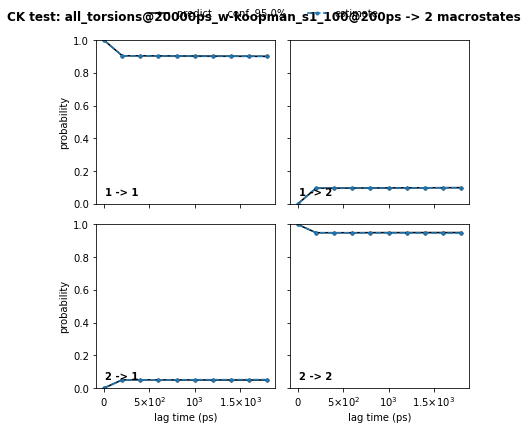

	CK test: all_torsions@20000ps_w-koopman_s1_100@200ps -> 3 macrostates


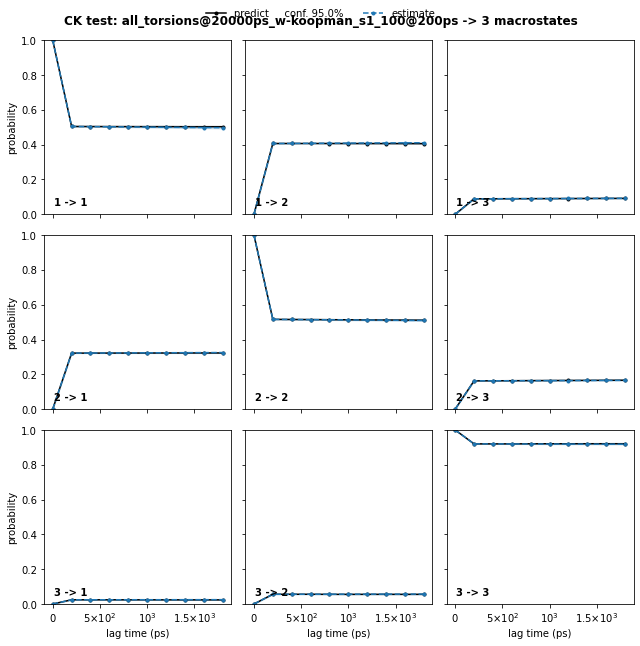

	CK test: all_torsions@20000ps_w-koopman_s1_100@200ps -> 4 macrostates


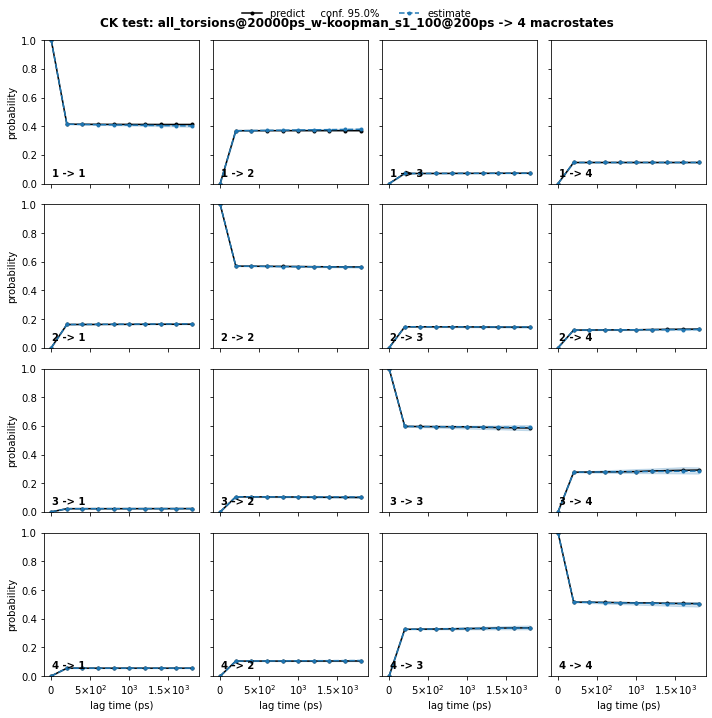

	CK test: all_torsions@20000ps_w-koopman_s1_100@200ps -> 5 macrostates


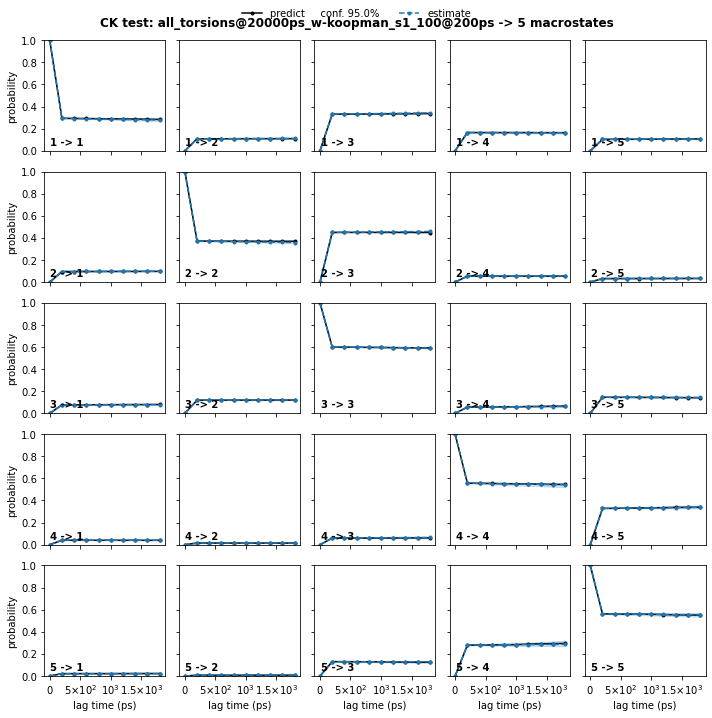

In [19]:
kinetics.analysis(inputs=top_model, tica_lag=tica_lag, tica_weights='koopman', method='CKtest')

## PCCA

Executing load_models 
	Models calculated:  1
	Models to discard:  0
	Models to calculate:  0
Executing load_discretized_data 
	Found TICA of all_torsions@20000ps_w-koopman_s1
	Total number of frames: 49997
	Number of trajectories: 20
	Frames/trajectory: [2498, 2500]
Executing PCCA_calculation 
	PCCA with 2 MSfor 100 cluster centers


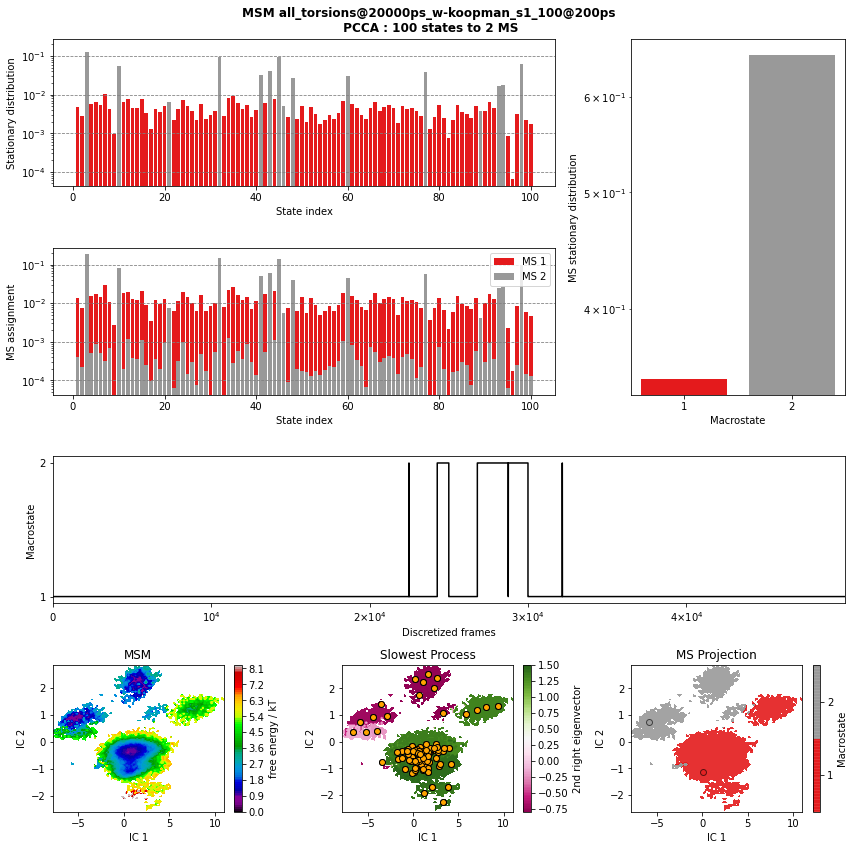

	PCCA with 3 MS


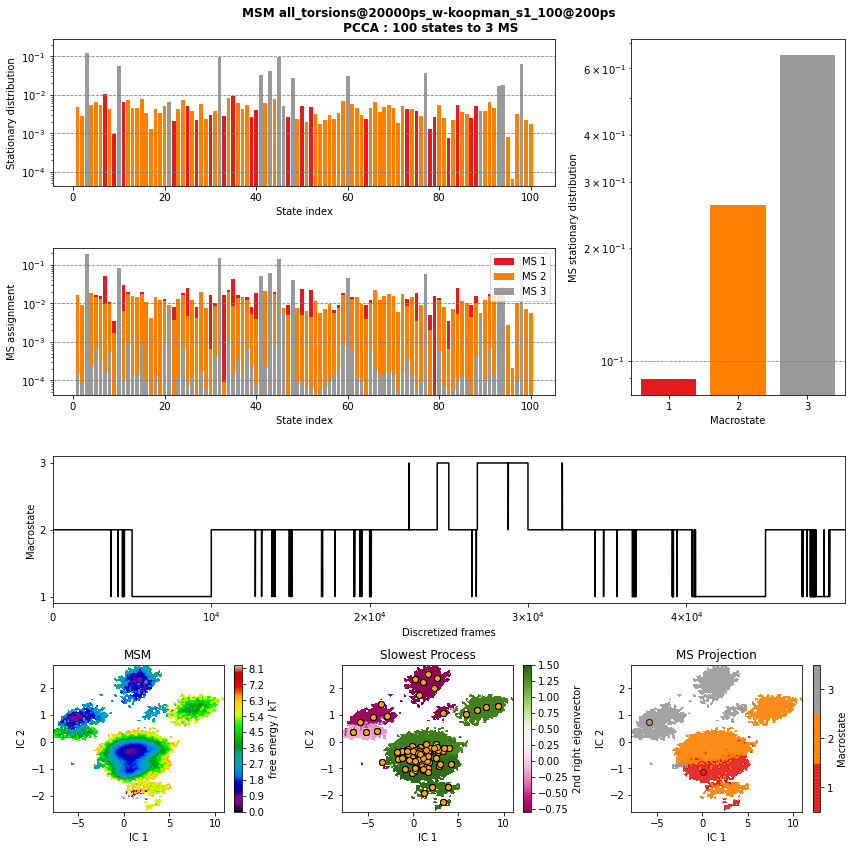

	PCCA with 4 MS


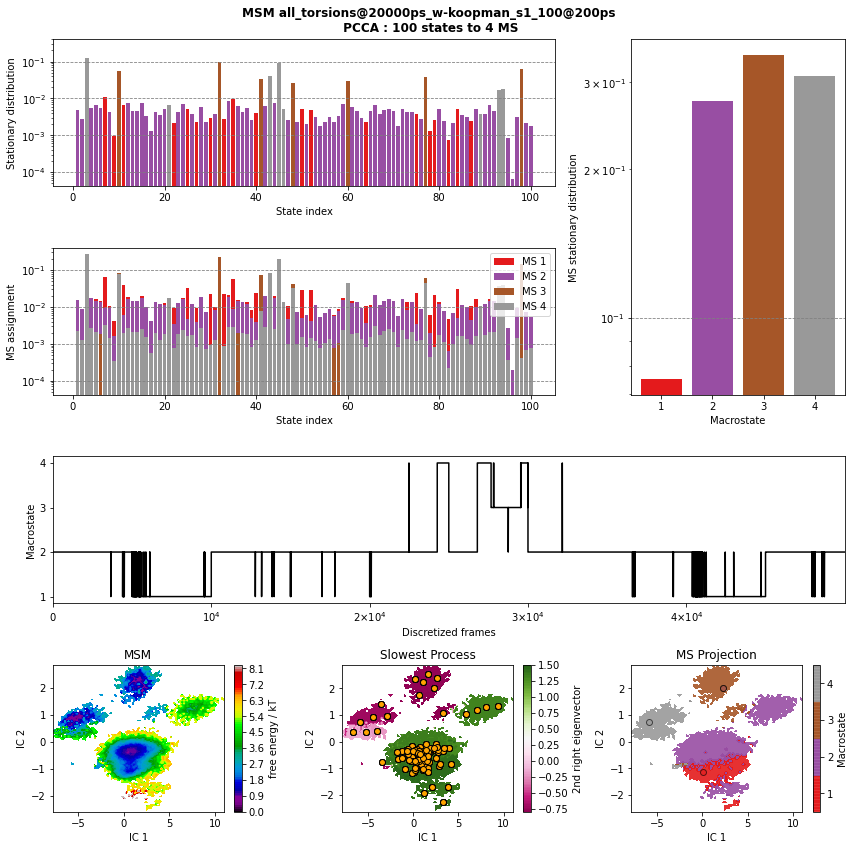

	PCCA with 5 MS


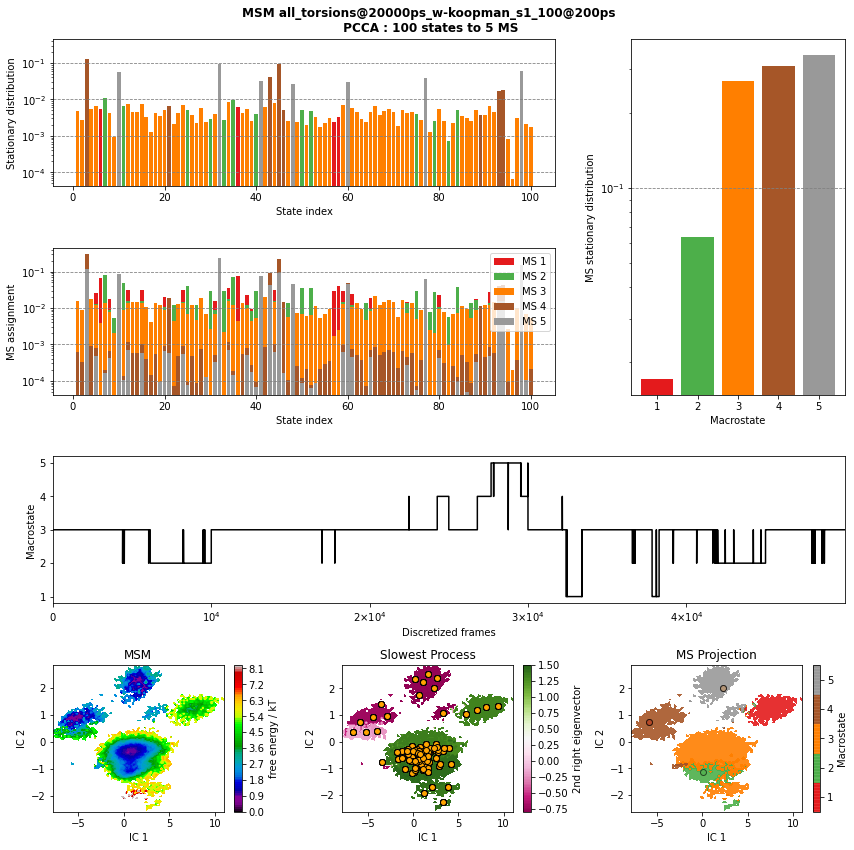

In [27]:
kinetics.analysis(inputs=top_model, tica_lag=tica_lag, tica_weights='koopman', method='PCCA')

In [72]:
top_model = [('all', 'torsions', 100, 10, 3)] #tICA lag 100, koopman
tica_lag = 1000

## MFPT

Executing load_models 
	Models calculated:  1
	Models to discard:  0
	Models to calculate:  0
Executing MFPT_calculation 


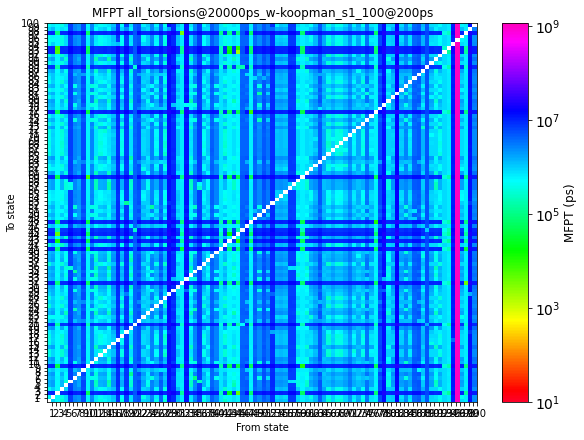

Coarse-graining with PCCA
Transition MS: 3 -> 3



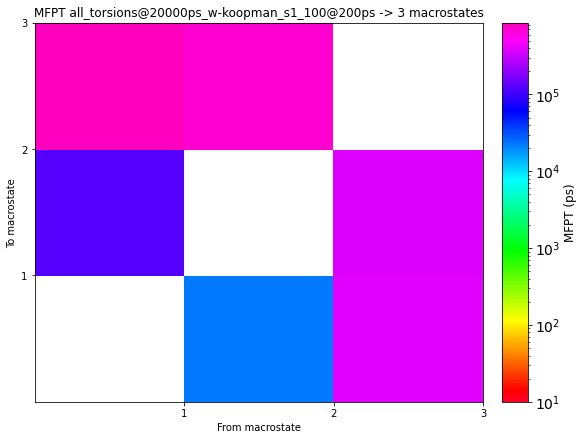

In [73]:
kinetics.analysis(inputs=top_model, tica_lag=tica_lag, tica_weights='koopman', method='MFPT')

## Implied Timescales

In [79]:
kinetics.analysis(inputs=top_model, tica_lag=tica_lag, tica_weights='koopman', method='ITS')

Executing load_models 
	Models calculated:  1
	Models to discard:  0
	Models to calculate:  0


AttributeError: 'MSM' object has no attribute 'discretized_data'

## Spectral analysis

Executing load_models 
	Models calculated:  1
	Models to discard:  0
	Models to calculate:  0
	3 processes resolved above 95.0% ITS (200 ps)


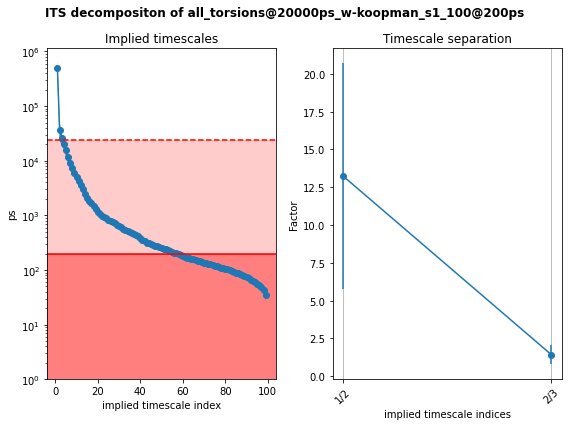

In [76]:
kinetics.analysis(inputs=top_model, tica_lag=tica_lag, tica_weights='koopman', method='Spectral')

In [77]:
kinetics.analysis(inputs=top_model, tica_weights='koopman', tica_lag=tica_lag, method='get_samples')

Executing load_models 
	Models calculated:  1
	Models to discard:  0
	Models to calculate:  0
	Generating 13*3macrostates = 40 samples from metastable distributions


Executing load_models 
	Models calculated:  1
	Models to discard:  0
	Models to calculate:  0
Executing flux_calculation 
	Performing coarse-grained TPT from A->I->B
	A = ['MS 3']
	B = ['MS 1']
	I = ['MS 2']
	Generating TPT trajectory 


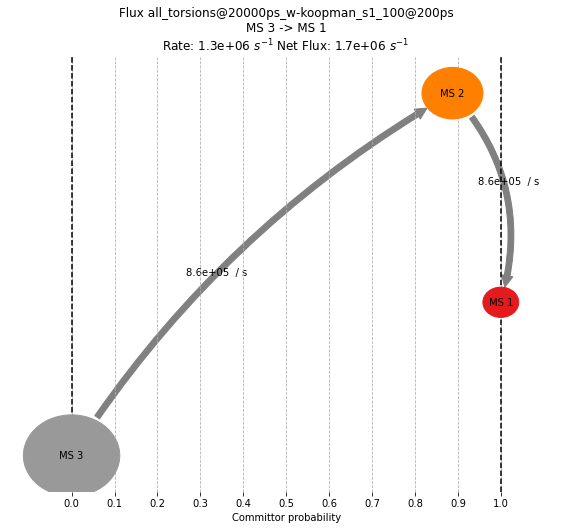

                             net flux          rate
name feature  model                                
all  torsions 100@200ps  1.718979e+06  1.265611e+06
                                 Forward  Backward
name feature  model     states                    
all  torsions 100@200ps MS 3    0.000000  1.000000
                        MS 2    0.887404  0.112596
                        MS 1    1.000000  0.000000
                                              % Total
name feature  model     pathway                      
all  torsions 100@200ps MS 3 -> MS 2 -> MS 1    100.0


In [81]:
top_model = [('all', 'torsions', 100, 10, 3, [[3], [1]])] 
kinetics.analysis(inputs=top_model, tica_lag=tica_lag, tica_weights='koopman', method='flux')

## Visualization

In [59]:
visual= kinetics.analysis(inputs=top_model, tica_weights='koopman', tica_lag=tica_lag, method='Visual')

Executing load_models 
	Models calculated:  1
	Models to discard:  0
	Models to calculate:  0
Could not assign inputs to resid ranges, reverting to "all".
/media/dataHog/hca/SETD2/results/h3K36-310K/MSM/MSM_storage/bayesMSM_all_torsions@20000ps_w-koopman_s1_100@200ps_PCCA1of5_v.dcd /media/dataHog/hca/SETD2/results/h3K36-310K/MSM/MSM_storage/bayesMSM_all_torsions@20000ps_w-koopman_s1_100@200ps_PCCA1of5_v.pdb
/media/dataHog/hca/SETD2/results/h3K36-310K/MSM/MSM_storage/bayesMSM_all_torsions@20000ps_w-koopman_s1_100@200ps_PCCA2of5_v.dcd /media/dataHog/hca/SETD2/results/h3K36-310K/MSM/MSM_storage/bayesMSM_all_torsions@20000ps_w-koopman_s1_100@200ps_PCCA2of5_v.pdb
/media/dataHog/hca/SETD2/results/h3K36-310K/MSM/MSM_storage/bayesMSM_all_torsions@20000ps_w-koopman_s1_100@200ps_PCCA3of5_v.dcd /media/dataHog/hca/SETD2/results/h3K36-310K/MSM/MSM_storage/bayesMSM_all_torsions@20000ps_w-koopman_s1_100@200ps_PCCA3of5_v.pdb
/media/dataHog/hca/SETD2/results/h3K36-310K/MSM/MSM_storage/bayesMSM_all_tors

## RDF

In [106]:
importlib.reload(Trajectory)
importlib.reload(F)

featurize=F.Featurize(project, results=results, timestep=timestep, warnings=True, heavy_and_fast=False)

rdf = featurize.calculate(('protein and not name H*', 'resname HOH and type O'), 
                    method='RDF',  
                    n_cores=4,
                    feature_name='SolvationShell',
                    def_traj=['production_NPT-1.dcd', 'production_NPT-2.dcd'])
rdf

Results will be stored under:  /media/dataHog/hca/SETD2/results/h3K36-310K
Loading pre-calculated RDF dataframe
l1        h3K36                                                              \
l2         310K                                                               
l3            1         2         3         4         5         6         7   
$G_r$                                                                         
0.1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.3    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.5    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.7    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.9    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
14.1   0.978087  0.971654  0.976128  0.976728  0.974385  0.971879  0.977689   
14.3   0.978828  0.

l1        h3K36                                                              \
l2         310K                                                               
l3            1         2         3         4         5         6         7   
$G_r$                                                                         
0.1    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.3    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.5    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.7    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
0.9    0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
...         ...       ...       ...       ...       ...       ...       ...   
14.1   0.978087  0.971654  0.976128  0.976728  0.974385  0.971879  0.977689   
14.3   0.978828  0.972943  0.977196  0.978207  0.975793  0.973581  0.978902   
14.5   0.980546  0.975491  0.978798  0.979027  0.977627  0.975748  0.979867   
14.7   0.981191  0.977086  0.979881  0.980288  0.978309  0.976500  0.981813   
14.9   0.982177  0.979065  0.981705  0.981559  0.979798  0.978257  0.982092   

l1                                   
l2                                   
l3            8         9        10  
$G_r$                                
0.1    0.000000  0.000000  0.000000  
0.3    0.000000  0.000000  0.000000  
0.5    0.000000  0.000000  0.000000  
0.7    0.000000  0.000000  0.000000  
0.9    0.000000  0.000000  0.000000  
...         ...       ...       ...  
14.1   0.976031  0.971260  0.972315  
14.3   0.977311  0.973306  0.974057  
14.5   0.978517  0.974392  0.975384  
14.7   0.979591  0.975905  0.977017  
14.9   0.981474  0.977470  0.977739  

[75 rows x 10 columns]

# 

In [101]:

rdf_reset=rdf.droplevel(level=[0,1], axis=1) #reset_index(drop=True)

In [107]:
rdf_reset.hvplot()

:NdOverlay   [l3]
   :Curve   [$G_r$]   (value)

In [108]:
rdf_reset.hvplot()

:NdOverlay   [l3]
   :Curve   [$G_r$]   (value)